In [ ]:
import pathlib

import cv2
import numpy as np
import PIL.Image

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
def rand_light_color() -> tuple[int, int, int]:
    return tuple(int(v) for v in np.random.randint(150, 256, 3))


def blur(img: np.ndarray, strength: int) -> np.ndarray:
    return cv2.GaussianBlur(img, (strength * 2 + 1, strength * 2 + 1), strength)


class BaseAugmenter:
    def generate_map(self, shape: tuple[int, int, int]) -> list[np.ndarray]:
        raise NotImplementedError

    def apply(self, img: np.ndarray) -> np.ndarray:
        aug_map = self.generate_map(img[:, :, :3].shape)
        img[:, :, :3] = cv2.add(img[:, :, :3], aug_map)
        if img.shape[-1] == 3:
            none_mask = np.zeros_like(img[:, :, 0])
            img = np.dstack([img, none_mask])
        aug_map = cv2.cvtColor(aug_map, cv2.COLOR_BGR2GRAY)
        img[:, :, 3] = cv2.add(img[:, :, 3], aug_map)
        return img


class VeilingGlareAdder(BaseAugmenter):
    def __init__(
        self,
        min_radius: int,
        max_radius: int,
        min_blur: int,
        max_blur: int,
        p_round: float,
    ):
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_blur = min_blur
        self.max_blur = max_blur
        self.p_round = p_round

    def generate_map(self, shape: tuple[int, int, int]) -> np.ndarray:
        g_map = np.zeros(shape=shape, dtype=np.uint8)
        # add ellipse
        pos = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
        if np.random.rand() < self.p_round:
            radius = np.random.randint(self.min_radius, self.max_radius)
            axes = (radius, radius)
        else:
            axes = np.random.randint(self.min_radius, self.max_radius, 2)
        angle = np.random.randint(0, 360)
        color = rand_light_color()
        cv2.ellipse(g_map, pos, axes, angle, 0, 360, color, -1)
        blur_strength = np.random.randint(self.min_blur, self.max_blur)
        g_map = blur(g_map, blur_strength)
        return g_map

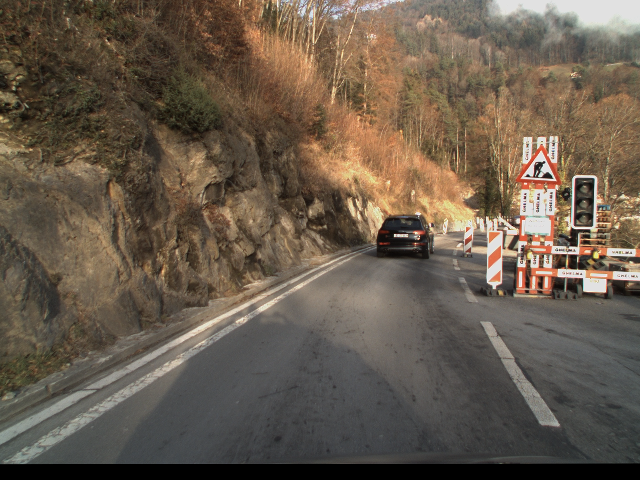

In [ ]:
img_paths = list(pathlib.Path("data/processed/dsec").rglob("*.npy"))
img = np.load(img_paths[0])[:, :, :3]
showarray(img[..., :3])

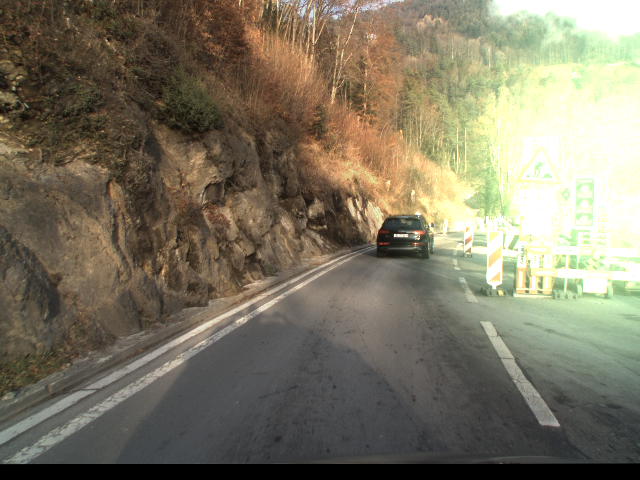

In [ ]:
vg_added = VeilingGlareAdder(10, 250, 10, 150, 0.6)
img_glared = vg_added.apply(img.copy())
showarray(img_glared[..., :3])

In [ ]:
class LensFlareAdder(BaseAugmenter):
    def __init__(
        self,
        min_objects: int,
        max_objects: int,
        min_size: int,
        max_size: int,
        min_strength: float,
        max_strength: float,
        p_add_line: float,
    ):
        self.min_objects = min_objects
        self.max_objects = max_objects
        self.p_add_line = p_add_line
        self.min_size = min_size
        self.max_size = max_size
        self.min_strength = min_strength
        self.max_strength = max_strength

    def _add_donut(
        self, img: np.ndarray, pos: tuple[int, int], size: int
    ) -> np.ndarray:
        cv2.circle(
            img,
            pos,
            np.random.randint(10, 50),
            rand_light_color(),
            np.random.randint(1, 5),
        )
        return img

    def _add_circle(
        self, img: np.ndarray, pos: tuple[int, int], size: int
    ) -> np.ndarray:
        cv2.circle(img, pos, np.random.randint(10, 50), rand_light_color(), -1)
        return img

    def _add_poly(self, img: np.ndarray, pos: tuple[int, int], size: int) -> np.ndarray:
        num_sides = np.random.randint(4, 8)
        points = []
        for j in range(num_sides):
            angle = j * (2 * np.pi / num_sides)
            x = pos[0] + int(size * np.cos(angle))
            y = pos[1] + int(size * np.sin(angle))
            points.append((x, y))

        cv2.fillPoly(img, [np.array(points)], rand_light_color())
        return img

    def _add_line(
        self, img: np.ndarray, line_start: tuple[int, int], line_end: tuple[int, int]
    ) -> np.ndarray:
        cv2.line(
            img, line_start, line_end, rand_light_color(), np.random.randint(1, 10)
        )
        img = blur(img, np.random.randint(5, 10))

        return img

    def generate_map(self, shape: tuple[int, int, int]) -> np.ndarray:
        flare_map = np.zeros(shape=shape, dtype=np.uint8)
        line_start = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
        line_end = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
        if np.random.rand() < self.p_add_line:
            flare_map = self._add_line(flare_map, line_start, line_end)

        candidate_points_on_line = np.linspace(line_start, line_end, 200)
        num_points = np.random.randint(self.min_objects, self.max_objects)
        np.random.shuffle(candidate_points_on_line)
        candidate_points_on_line = candidate_points_on_line[:num_points].astype(
            np.int32
        )
        candidate_funcs = [self._add_donut, self._add_circle, self._add_poly]
        for point in candidate_points_on_line:
            size = np.random.randint(self.min_size, self.max_size)
            func = np.random.choice(candidate_funcs)
            flare_map = func(flare_map, point, size)
        flare_map = (blur(flare_map, np.random.randint(1, 5)) * 0.6).astype(np.uint8)
        return flare_map

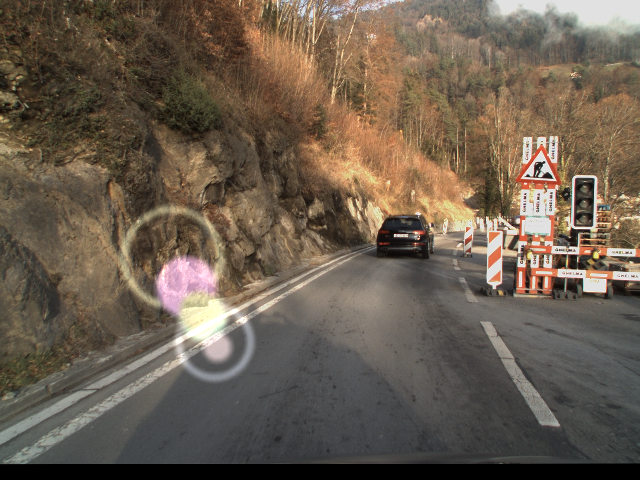

In [ ]:
lf_adder = LensFlareAdder(1, 10, 5, 100, 0.25, 0.8, 0.2)
img_flared = lf_adder.apply(img.copy())
showarray(img_flared[:, :, :3])

In [ ]:
class SunAdder(BaseAugmenter):
    def __init__(
        self,
        min_size: int,
        max_size: int,
        min_outer_strength: float,
        max_outer_strength: float,
        p_rays: float,
        p_outer: float,
    ):
        self.min_size = min_size
        self.max_size = max_size
        self.min_outer_strength = min_outer_strength
        self.max_outer_strength = max_outer_strength
        self.p_rays = p_rays
        self.p_outer = p_outer

    def _add_rays(
        self, img: np.ndarray, pos: tuple[int, int], color: tuple[int, int, int]
    ) -> np.ndarray:
        ray_map = np.zeros_like(img)
        num_rays = np.random.randint(2, 30)
        for _ in range(num_rays):
            angle = np.random.uniform(0, 2 * np.pi)
            ray_length = np.random.randint(50, 250)
            ray_end = (
                pos[0] + int(ray_length * np.cos(angle)),
                pos[1] + int(ray_length * np.sin(angle)),
            )
            cv2.line(ray_map, pos, ray_end, color, np.random.randint(1, 5))

        ray_map = blur(ray_map, 5)
        strong_ray_radius = np.random.randint(50, 200)
        multiplier = np.zeros_like(img, dtype=np.float32)
        cv2.circle(multiplier, pos, strong_ray_radius, (1.0, 1.0, 1.0), -1)
        multiplier = blur(multiplier, 50)
        ray_map = (ray_map * multiplier).astype(np.uint8)
        img = cv2.add(img, ray_map)
        return img

    def generate_map(self, shape: tuple[int, int, int]) -> np.ndarray:
        s_map = np.zeros(shape=shape, dtype=np.uint8)
        pos = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
        size = np.random.randint(self.min_size, self.max_size)
        outer_radius = np.random.randint(10 * size, 16 * size)
        inner_radius = np.random.randint(2 * size, 4 * size)
        color = rand_light_color()
        if np.random.rand() < self.p_outer:
            cv2.circle(s_map, pos, outer_radius, color, -1)
            outer_strength = np.random.uniform(
                self.min_outer_strength, self.max_outer_strength
            )
            s_map = (s_map * outer_strength).astype(np.uint8)
            s_map = blur(s_map, 50)

        cv2.circle(s_map, pos, inner_radius, color, -1)
        s_map = blur(s_map, 20)

        cv2.circle(s_map, pos, size, (255, 255, 255), -1)

        if np.random.rand() < self.p_rays:
            s_map = self._add_rays(s_map, pos, color)
        s_map = blur(s_map, 5)

        return s_map

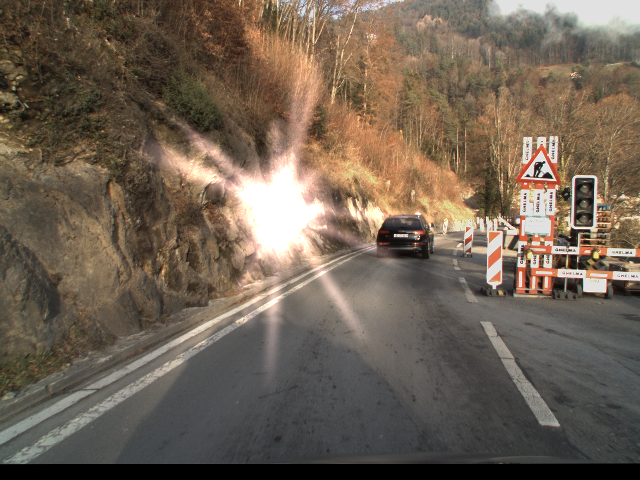

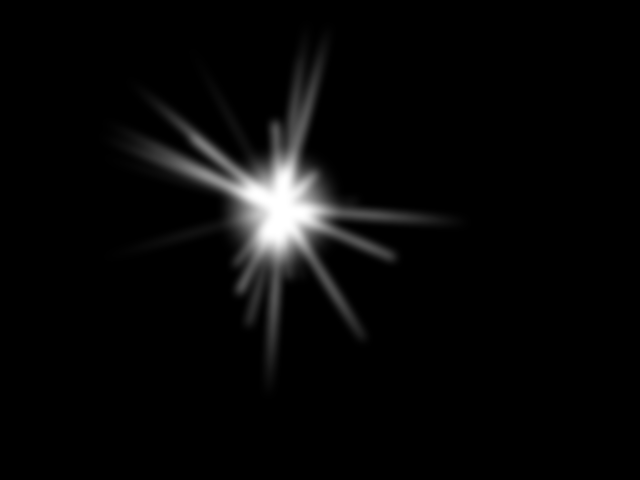

In [169]:
s_adder = SunAdder(4, 25, 0.0, 0.8, 0.2, 0.5)
img_sunned = s_adder.apply(img.copy())
showarray(img_sunned[:, :, :3])
showarray(img_sunned[:, :, 3])